In this experiment, we use t-SNE to embed events, represented by: article count (here lies the key difference), event date, title, and summary

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from openTSNE import TSNE
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_pickle("../data/text/data_with_embeds.pkl")

In [3]:
df.head()

,lang,title,summary,article_count,event_date,title_embed,summary_embed
id,,,,,,,
e_11,eng,Bombing survivor and nurse to wed,A man seriously wounded in the Boston bombing ...,7,16057,"[0.47470707, -0.08501352, 0.26899937, -0.36353...","[0.3377615, -0.26158097, 0.3140225, -0.2120716..."
e_10,eng,Trade Idea: GBP/USD - Sell at 1.6450,Although the British pound rallied to 1.6485 y...,221,16058,"[0.17094071, -0.18888026, 0.28712985, -0.36104...","[0.1786896, -0.11662727, 0.19326286, -0.20948,..."
e_13,eng,Too cool for Yule? Have a hipster Christmas in...,"Unlike you, hipsters don't want any old Christ...",9,16059,"[0.2537402, -0.032281302, 0.37904784, -0.31818...","[0.026874868, -0.09318099, 0.03552014, -0.0260..."
e_12,eng,Opening Bell: Cues that will help you trade be...,"The Sensex plunged 210.03 points to 20,715.58 ...",1,16054,"[0.23880291, 0.03649398, 0.32137018, -0.170995...","[0.46094257, -0.36103615, 0.31917268, -0.60180..."
e_15,eng,On Colorado shooter's arm...,(CNN) -- Colorado shooter Karl Pierson had wri...,8,16057,"[0.3985864, -0.06734807, 0.40732777, -0.461210...","[0.5053371, -0.062929116, 0.27972195, -0.43177..."


In [4]:
# graph = pickle.load(open("../data/graphs/100_concepts_similar_llm_noUnknown.pkl", "rb"))

In [5]:
print(f"{np.sum(df['article_count'] >= 40) / df.shape[0] * 100:.2f}% of rows have >= 40 articles")

4.65% of rows have >= 40 articles


In [6]:
event_dates = df['event_date'].values.reshape(-1, 1)
article_counts = df['article_count'].values.reshape(-1, 1)

x = np.concatenate([article_counts, event_dates, df['title_embed'].tolist(), df['summary_embed'].tolist()], axis=1)
y = df['article_count']

In [7]:
if os.path.exists("../data/text/tsne_train_test.pkl"):
    print("Loading train test split from pickle")
    x_train, x_test, y_train, y_test = pickle.load(open("../data/text/tsne_train_test.pkl", "rb"))
else:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    pickle.dump((x_train, x_test, y_train, y_test), open("../data/text/tsne_train_test.pkl", "wb"))

Loading train test split from pickle


In [8]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

155248 training samples
38813 test samples


In [9]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

In [10]:
if os.path.exists("../data/text/llm_tsne_train_counts.pkl"):
    print("Loading tSNE from pickle")
    embedding_train = pickle.load(open("../data/text/llm_tsne_train_counts.pkl", "rb"))
    embedding_test = pickle.load(open("../data/text/llm_tsne_test_counts.pkl", "rb"))
else:
    print("Fitting train TSNE")
    embedding_train = tsne.fit(x_train)
    embedding_test = embedding_train.transform(x_test)
    print("Saving to pickle")
    pickle.dump(embedding_train, open("../data/text/llm_tsne_train_counts.pkl", "wb"))
    pickle.dump(embedding_test, open("../data/text/llm_tsne_test_counts.pkl", "wb"))

print("Done")

Loading tSNE from pickle
Done


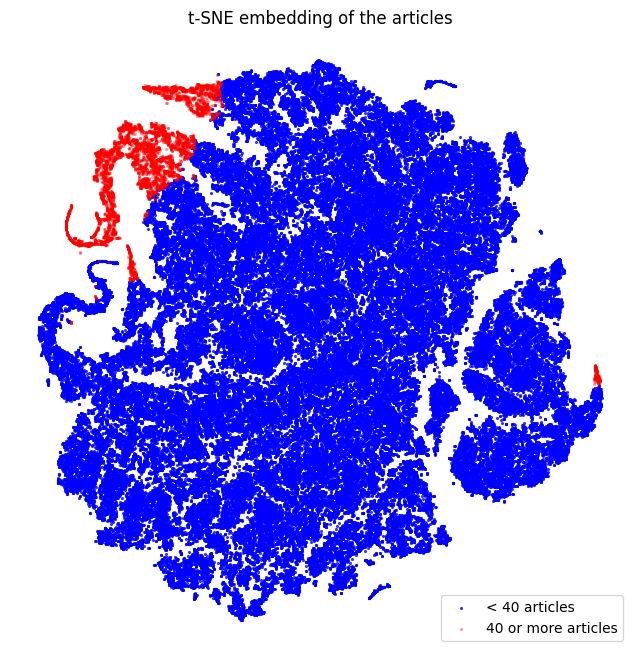

In [11]:
plt.figure(figsize=(8, 8))

mask = y_train >= 40

plt.scatter(embedding_train[~mask, 0], embedding_train[~mask, 1], 
            c='blue', alpha=0.8, s=5, linewidths=0, label="< 40 articles")
plt.scatter(embedding_train[mask, 0], embedding_train[mask, 1], 
            c='red', alpha=0.4, s=5, linewidths=0, label="40 or more articles")

plt.axis('off')
plt.title("t-SNE embedding of the articles")
plt.legend()


plt.show()

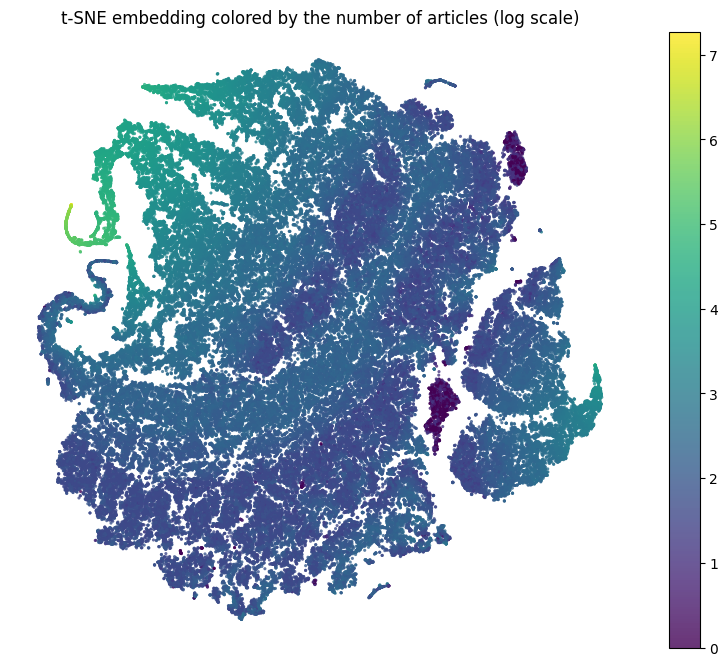

In [13]:
train_idx = y_train.index
y_counts = df.loc[train_idx]['article_count']
counts_log = y_counts.apply(lambda x: np.log(x))

plt.figure(figsize=(10, 8))

plt.scatter(embedding_train[:, 0], embedding_train[:, 1], 
            c=counts_log, alpha=0.8, s=5, linewidths=0, cmap='viridis')

plt.axis('off')
plt.title("t-SNE embedding colored by the number of articles (log scale)")
plt.colorbar()

plt.show()

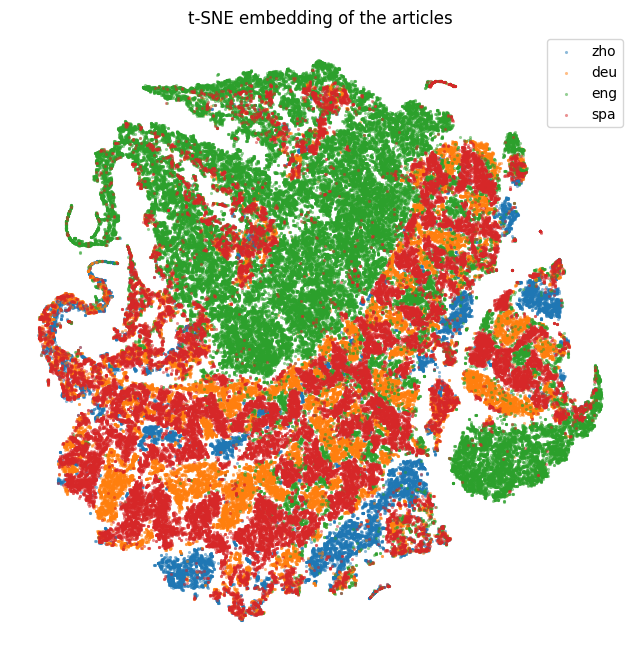

In [14]:
plt.figure(figsize=(8, 8))

df_train = df.loc[y_train.index]
for lang in df_train['lang'].unique():
    mask = df_train['lang'] == lang
    plt.scatter(embedding_train[mask, 0], embedding_train[mask, 1], 
                alpha=0.5, s=5, linewidths=0, label=lang)

plt.axis('off')
plt.title("t-SNE embedding of the articles")
plt.legend()

plt.show()

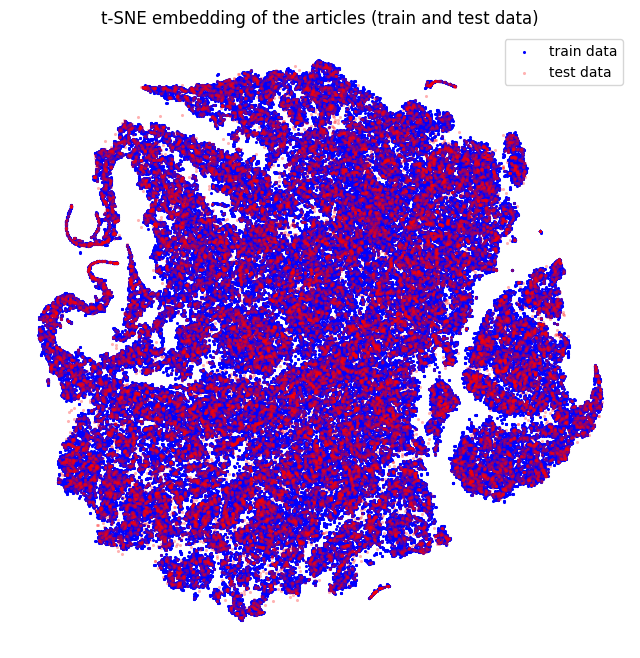

In [15]:
# plot the test embeddings on top of the train embeddings

plt.figure(figsize=(8, 8))

# Training data (blue)

plt.scatter(embedding_train[:, 0], embedding_train[:, 1], 
            c='blue', alpha=1, s=5, linewidths=0, label="train data")

# Test data (red)

plt.scatter(embedding_test[:, 0], embedding_test[:, 1], 
            c='red', alpha=0.3, s=5, linewidths=0, label="test data")

plt.axis('off')
plt.title("t-SNE embedding of the articles (train and test data)")
plt.legend()

plt.show()


In [17]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [28]:
# Create the KNN regressor with the number of neighbors you want to consider
knn = KNeighborsRegressor(n_neighbors=5)

# Train the regressor on the training data
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [29]:
# Make predictions on the test data
y_pred = knn.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 318.0352624120784


This result is not an actual prediction, because we're using the article counts as an input feature (in a separate experiment that didn't include article_counts at all, the mse was ~490).
However, this experiment is useful to show that even with 'cheating' and using the article counts as an input feature, the model is still not able to predict the number of articles very well.

Comparing the two experiments (one with cheating and one without), we can see that the mse is very similar, which gives a lot of weight to the hypothesis that the LLM embeddings should greatly improve the performance of our GNN model (if nothing else, at least alleviating the language bias).

TODO: visualizations of how event dates affect the embeddings
TODO: heatmap of the article counts, normalized by language counts

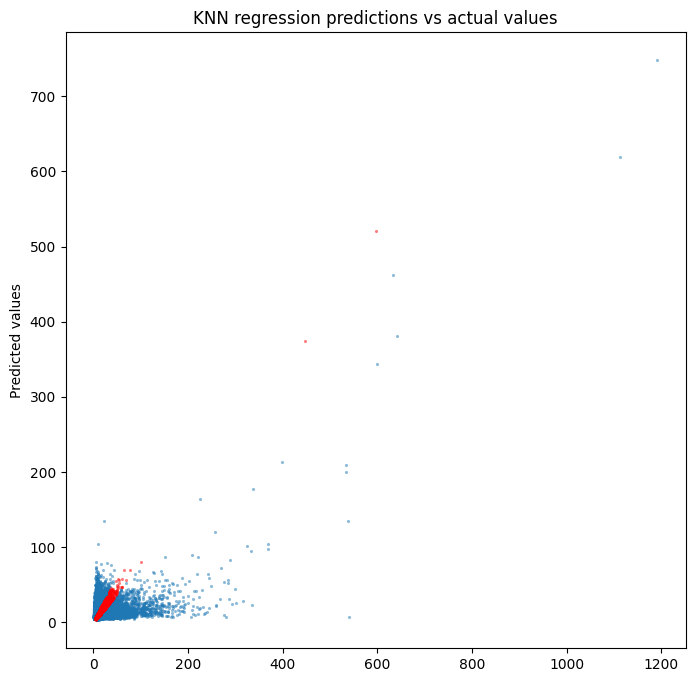

In [33]:
# Plot the predictions vs the actual values
plt.figure(figsize=(8, 8))

# plt.scatter(y_test, y_pred, alpha=0.25, s=10, linewidths=0)
# plt.xlabel("Actual values")

# color the points that are within 25% of the actual value in red
mask = np.abs(y_test - y_pred) / y_test <= 0.25
plt.scatter(y_test[~mask], y_pred[~mask], alpha=0.5, s=5, linewidths=0)
plt.scatter(y_test[mask], y_pred[mask], alpha=0.5, s=5, linewidths=0, c='red')


plt.ylabel("Predicted values")
plt.title("KNN regression predictions vs actual values")

plt.show()

In [31]:
y_pred_sorted = np.sort(y_pred)[::-1]
y_test_sorted = np.sort(y_test)[::-1]
def get_top_x_L1(percent=0.1):
    top_percent = int(y_test.shape[0] * percent)
    
    y_test_p = y_test_sorted[:top_percent]
    y_pred_p = y_pred_sorted[:top_percent]
    
    mean_l1_error = np.mean(np.abs(y_test_p - y_pred_p))
    mean_relative_error = np.mean(np.abs(y_test_p - y_pred_p) / y_test_p)
    print(f"Mean L1 error for the top {round(x * 100)}% of rows with the most articles: {round(mean_l1_error, 2)} ({round(mean_relative_error * 100, 2)}%)")

In [32]:
for x in [0.1, 0.2, 0.3, 0.4, 0.5, 1]:
    get_top_x_L1(x)

Mean L1 error for the top 10% of rows with the most articles: 21.26 (30.4%)
Mean L1 error for the top 20% of rows with the most articles: 11.31 (19.37%)
Mean L1 error for the top 30% of rows with the most articles: 8.22 (18.57%)
Mean L1 error for the top 40% of rows with the most articles: 6.56 (17.88%)
Mean L1 error for the top 50% of rows with the most articles: 5.45 (16.52%)
Mean L1 error for the top 100% of rows with the most articles: 3.52 (25.74%)
